In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))


if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

tf.__version__
tf.keras.__version__

TensorFlow Version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


'2.4.0'

In [38]:
# library
import pandas as pd
import os 
import feather
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
from scipy.special import logsumexp
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow import keras
from utils import *

In [3]:
# read in 
WU = feather.read_dataframe('Data/WU.feather')

#pp
WU = WU.drop(columns=['Index','year','ParcelID','Days','year','month'])

p_scalar = preprocessing.StandardScaler()
predictors = ['TotalWaterUse','ET_turf_month_mean']
p_scalar.fit(WU.loc[:,predictors])
WU.loc[:,predictors] = p_scalar.transform(WU.loc[:,predictors])

nlag = 7
WU_lag = add_group_lags(data=WU, group='E_Label_ParcelID', timeindex='monthIndex',
                        features = ['TotalWaterUse','ET_turf_month_mean'], other = ['Set'], nlag=nlag,fillna=None)

WU_lag_dropna = WU_lag.dropna()

# Tensor generating

In [4]:
# must take in add_group_lag object
# target not used for forecasting!!! instead, shift your X!!!
def lstmtensor(data,feature_patters,target, sets): 
    #generate whole tensor: out
    for i,p in enumerate(feature_patters):
    
        X = data.filter(like=p,axis=1).values
        xshape = X.shape
        Xre = X.reshape(xshape[0],xshape[1],1)
    
        if(i == 0):
            out = Xre
        else:
            out = np.concatenate([out,Xre],axis=2)
    
    # whole target: y (can be a 2D tensor or 1D vector)
    y = data.loc[:,target].values
    
    # split tensor into dict: outdict, outydict
    setnames = data.loc[:,sets].unique()
    outdict = {}
    outydict = {}
    for s in setnames:
        Xs = out[(data.loc[:,sets] == s),:,:][:,::-1,:]
        ys = y[(data.loc[:,sets] == s)]
        #print(Xs.shape)
        Xdict = {s: Xs}
        outdict.update(Xdict)
        ydict = {s:ys}
        outydict.update(ydict)
    
    return outdict, outydict

            
    

In [5]:
predictors = ['TotalWaterUse','ET_turf_month_mean']
Xdict, ydict = lstmtensor(data=WU_lag_dropna,
                          feature_patters= predictors,
                          target='TotalWaterUse',
                          sets='Set')

In [6]:
# find batch size 
# can skip this chunck and directly define a batch size
bs_remain_list = []
bs_list=[]
for bs in np.arange(16, 500):
    r_train = Xdict['train'].shape[0]%bs
    r_dev = Xdict['dev'].shape[0]%bs
    bs_remain_list.append(r_train+r_dev)
    bs_list.append(bs)
    
batch_size = pd.Series(bs_remain_list,index=bs_list).idxmin() 

batch_size=32
r_train = Xdict['train'].shape[0]%batch_size
r_dev = Xdict['dev'].shape[0]%batch_size
r_test = Xdict['test'].shape[0]%batch_size

s=Xdict['train'].shape[0]//batch_size

In [7]:
target_axis = 0

In [8]:
def buildmodel(n_hidden = 1, dense_dp = 0, recurrent_dp= 0 ,l2=0.001, training = None):
    
    Input_ = keras.layers.Input(shape = Xdict['train'][r_train:,:-1,:].shape[1:])
    
    Z = Input_
    for _ in range(n_hidden):
        Z = GRU(32, input_shape = (nlag,len(predictors)),
                  recurrent_dropout = recurrent_dp,
                  dropout = dense_dp,
                  kernel_regularizer=keras.regularizers.l2(l2),
                  return_sequences = True)(Z,training = training)

    Z = TimeDistributed(Dense(32, kernel_regularizer=keras.regularizers.l2(l2),
                              activation = 'elu',kernel_initializer='he_normal'))(Z)
    Z = Dropout(rate=dense_dp)(Z,training = training)
    Z = TimeDistributed(Dense(32, kernel_regularizer=keras.regularizers.l2(l2),
                              activation = 'elu',kernel_initializer='he_normal'))(Z)
    Z = Dropout(rate=dense_dp)(Z,training = training)
    Output_ = Dense(1)(Z)
    
    model = keras.Model(inputs=[Input_],outputs=[Output_])
    return model

del model
tf.keras.backend.clear_session()

In [9]:
n_hidden = 1
dp_rate=0.1
r_dp = 0
l2=0.00001
lr=1e-5

In [10]:
# seq API
model = buildmodel(n_hidden = n_hidden, dense_dp = dp_rate, recurrent_dp=r_dp,l2=l2)

In [11]:
@tf.function
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1,0], Y_pred[:,-1,0])

model.compile(optimizer = Adam(learning_rate=lr), loss = 'mean_squared_error',metrics = [last_time_step_mse] )
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 2)]            0         
_________________________________________________________________
gru (GRU)                    (None, 7, 32)             3456      
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 32)             1056      
_________________________________________________________________
dropout (Dropout)            (None, 7, 32)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 32)             1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 1)             

In [12]:
callback_list =[
    callbacks.EarlyStopping(
        monitor = 'val_last_time_step_mse',
        restore_best_weights=True,
        patience= 5
    ),
    callbacks.ModelCheckpoint(
        filepath='LSTM_log/lstm_dev_1m.h5',
        save_best_only= True,
        monitor='val_last_time_step_mse'
    ),
    #callbacks.ReduceLROnPlateau(factor=0.5,patience=5), # eta performance scheduling
#     callbacks.TensorBoard(log_dir='LSTM_log',histogram_freq=1)
]

In [13]:
# seed
tf.random.set_seed(1)
np.random.seed(1)

history = model.fit(x= Xdict['train'][r_train:,:-1,:],
                    y= Xdict['train'][r_train:,1:,target_axis].reshape(-1,nlag,1), # shift one time point
                    epochs= 100,
                    batch_size= batch_size,
                    validation_data=( Xdict['dev'][r_dev:,:-1,:],Xdict['dev'][r_dev:,1:,target_axis].reshape(-1,nlag,1)),
                    callbacks=callback_list)

Epoch 1/100
331/331 [==============================] - 2s 7ms/step - loss: 0.6443 - last_time_step_mse: 0.6380 - val_loss: 0.4838 - val_last_time_step_mse: 0.4567
Epoch 2/100
331/331 [==============================] - 1s 4ms/step - loss: 0.4404 - last_time_step_mse: 0.4114 - val_loss: 0.3307 - val_last_time_step_mse: 0.2907
Epoch 3/100
331/331 [==============================] - 1s 4ms/step - loss: 0.3311 - last_time_step_mse: 0.2891 - val_loss: 0.2496 - val_last_time_step_mse: 0.2136
Epoch 4/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2790 - last_time_step_mse: 0.2476 - val_loss: 0.2136 - val_last_time_step_mse: 0.1878
Epoch 5/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2613 - last_time_step_mse: 0.2420 - val_loss: 0.1994 - val_last_time_step_mse: 0.1819
Epoch 6/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2555 - last_time_step_mse: 0.2361 - val_loss: 0.1929 - val_last_time_step_mse: 0.1796
Epoch 7/100
331/331 [=

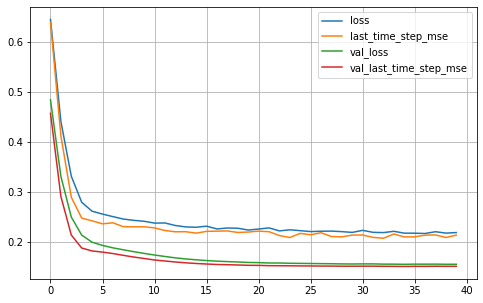

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

In [15]:
pred = model.predict(Xdict['dev'][:,:-1,:],batch_size=batch_size)[:,nlag-1,0]

ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
pred_inv_trans = pred*np.sqrt(yvar)+ymean
y_true = ydict['dev']*np.sqrt(yvar)+ymean

In [16]:
stop_epoch = pd.Series(history.history['val_last_time_step_mse'],index = history.epoch).idxmin()

# Tune tau

In [18]:
@tf.function
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1,0], Y_pred[:,-1,0])

In [19]:
mc_model =  buildmodel(n_hidden = n_hidden, dense_dp = dp_rate, recurrent_dp=r_dp,l2=l2,training=True)
mc_model.set_weights(model.get_weights())


In [20]:
T= 1000
tf.random.set_seed(1)
np.random.seed(1)
X_test_tf = tf.constant( Xdict['dev'][:,:-1,:], dtype=tf.float32 )


y_probas = np.stack([mc_model.predict(X_test_tf, batch_size=batch_size*100)[:,-1,0]
                     for sample in range(T)])
print('done')




done


In [22]:
ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
y_hat_MC = y_probas * np.sqrt(yvar)+ymean
y_hat = y_hat_MC.mean(axis=0)
y_true = ydict['dev']*np.sqrt(yvar)+ymean

In [25]:
grid_ll = []
taul, tl = [], []
for t in range(100):
    tau = 2**(-t)
    ll = (logsumexp(-0.5 * tau * (y_true - y_hat_MC)**2., 0) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)
    taul.append(tau)
    grid_ll.append(test_ll)
    tl.append(t)
    
best_t = tl[grid_ll.index(max(grid_ll))]
best_tau = taul[grid_ll.index(max(grid_ll))]
best_tau, best_t, max(grid_ll)

G = 100
gg = (taul[grid_ll.index(max(grid_ll))-1] - taul[grid_ll.index(max(grid_ll))+1])/G

grid_ll = []
taul, tl = [], []
for t in range(G):
    tau = 2**(-best_t-1) +  gg*t
    ll = (logsumexp(-0.5 * tau * (y_true - y_hat_MC)**2., 0) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)
    taul.append(tau)
    grid_ll.append(test_ll)
    tl.append(t)
    
rmse = round(np.sqrt(mean_squared_error(y_true,y_hat)),4) 

best_t = tl[grid_ll.index(max(grid_ll))]
best_tau = taul[grid_ll.index(max(grid_ll))]
sig = np.sqrt(1/best_tau)
print('final tune value: tau:{} t:{} LL:{} RMSE:{}'.format(best_tau, best_t, max(grid_ll),rmse ))

In [30]:
# hyper-par: tau
np.random.seed(1)
y_MC_mixture = np.concatenate([np.random.normal(loc=samplei,scale=sig,size=(10,len(samplei))) for samplei in y_hat_MC] , axis=0)

In [33]:
alpha= 0.05
L_hat = np.quantile(y_MC_mixture,alpha/2,axis=0)
U_hat = np.quantile(y_MC_mixture,(1-alpha/2),axis=0)
left = L_hat
right = U_hat
py_all = np.stack([norm.pdf(y_true, loc=samplei, scale=sig) for samplei in y_hat_MC])
p_y = py_all.mean(axis=0)
sig_hat2 = y_MC_mixture.std(axis=0)

# save to dev MF

In [34]:
WU2 = feather.read_dataframe('Data/WU.feather')
WU2[WU2.loc[:,'Set']=='dev'].loc[:,'Index'].values


all_dev_MF = pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='dev'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'L': left,
    'U': right,
    'sig_hat': sig_hat2,
    'p_y':p_y
})

path = 'Out_dev_MF\\month1\\LSTM_MC_dev_1m_dist.feather'
feather.write_dataframe(all_dev_MF , path)

# write sample for ECPI
path = 'Out_dev_MF\\month1\\LSTM_MC.npy'
np.save(path, y_MC_mixture)


In [35]:

del model
tf.keras.backend.clear_session()

# Test

In [36]:
model = buildmodel(n_hidden = n_hidden, dense_dp = dp_rate, recurrent_dp=r_dp,l2=l2)

model.compile(optimizer = Adam(learning_rate=lr), loss = 'mean_squared_error',metrics = [last_time_step_mse] )
model.summary()


In [39]:
callback_list =[
    callbacks.EarlyStopping(
        monitor = 'val_last_time_step_mse',
        patience= stop_epoch
    ),
    callbacks.ModelCheckpoint(
        filepath='LSTM_log/lstm_MC_1m.h5',
        #save_best_only= True,
        monitor='val_last_time_step_mse'
    ),
]

In [40]:
train_all = np.concatenate([Xdict['train'],Xdict['dev']], axis= 0)
batch_size=32
r_train = train_all.shape[0]%batch_size
r_test = Xdict['test'].shape[0]%batch_size

(24, 16)

In [41]:
target_axis = 0
history = model.fit(x= train_all[r_train:,:-1,:],
                    y= train_all[r_train:,1:,target_axis].reshape(-1,nlag,1), # shift one time point
                    epochs= stop_epoch,
                    batch_size= batch_size,
                    validation_data=( Xdict['test'][:,:-1,:],Xdict['test'][:,1:,target_axis].reshape(-1,nlag,1)),
                    callbacks=callback_list)


Epoch 1/34
368/368 [==============================] - 2s 6ms/step - loss: 1.6167 - last_time_step_mse: 1.7336 - val_loss: 1.3492 - val_last_time_step_mse: 1.3110
Epoch 2/34
368/368 [==============================] - 2s 4ms/step - loss: 1.1140 - last_time_step_mse: 1.1280 - val_loss: 0.9188 - val_last_time_step_mse: 0.8298
Epoch 3/34
368/368 [==============================] - 2s 4ms/step - loss: 0.7671 - last_time_step_mse: 0.7181 - val_loss: 0.6231 - val_last_time_step_mse: 0.5181
Epoch 4/34
368/368 [==============================] - 2s 4ms/step - loss: 0.5388 - last_time_step_mse: 0.4655 - val_loss: 0.4362 - val_last_time_step_mse: 0.3403
Epoch 5/34
368/368 [==============================] - 2s 4ms/step - loss: 0.4004 - last_time_step_mse: 0.3313 - val_loss: 0.3329 - val_last_time_step_mse: 0.2604
Epoch 6/34
368/368 [==============================] - 2s 4ms/step - loss: 0.3301 - last_time_step_mse: 0.2807 - val_loss: 0.2833 - val_last_time_step_mse: 0.2365
Epoch 7/34
368/368 [========

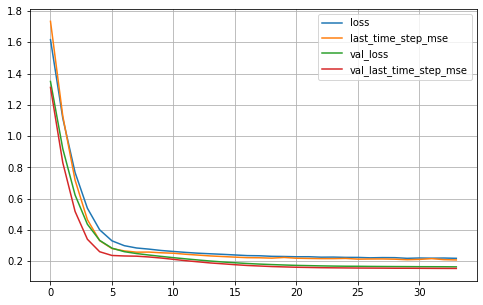

In [42]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [43]:
pred = model.predict(Xdict['test'][:,:-1,:],batch_size=batch_size)[:,-1,0]
ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
pred_inv_trans = pred*np.sqrt(yvar)+ymean
y_true = ydict['test']*np.sqrt(yvar)+ymean

# MC dropout

In [44]:
@tf.function
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1,0], Y_pred[:,-1,0])

mc_model =  buildmodel(n_hidden = n_hidden, dense_dp = dp_rate, recurrent_dp=r_dp,l2=l2,training=True)
mc_model.set_weights(model.get_weights())


In [45]:
T= 1000
tf.random.set_seed(1)
np.random.seed(1)
X_test_tf = tf.constant( Xdict['test'][:,:-1,:], dtype=tf.float32 )


y_probas = np.stack([mc_model.predict(X_test_tf, batch_size=batch_size*100)[:,-1,0]
                     for sample in range(T)])
print('done')

done


In [46]:
ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
y_hat_MC = y_probas * np.sqrt(yvar)+ymean
y_hat = y_hat_MC.mean(axis=0)
y_true = ydict['test']*np.sqrt(yvar)+ymean

In [48]:
# hyper-par: tau
np.random.seed(1)
y_MC_mixture = np.concatenate([np.random.normal(loc=samplei,scale=sig,size=(10,len(samplei))) for samplei in y_hat_MC] , axis=0)

In [51]:
L_hat = np.quantile(y_MC_mixture,alpha/2,axis=0)
U_hat = np.quantile(y_MC_mixture,(1-alpha/2),axis=0)
left = L_hat
right = U_hat
py_all = np.stack([norm.pdf(y_true, loc=samplei, scale=sig) for samplei in y_hat_MC])
p_y = py_all.mean(axis=0)
sig_hat2 = y_MC_mixture.std(axis=0)

In [137]:
r1,r2,r3,r4,r5 = get_RMSE_NLL_NOIS_AWPI_ECPI(y_true,y_hat,left,right,alpha=0.05)

 & 1172.73 & 8.48 & 6365.39 & 5032.86 & 0.95 & 95\% \\


(1172.7334049132792,
 8.479329697975396,
 6365.391025868944,
 5032.8619253199295,
 0.9483333333333334)

# Save


In [52]:
WU2 = feather.read_dataframe('Data/WU.feather')

all_test_MF_LSTM = pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='test'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'L': left,
    'U': right,
    'sig_hat': sig_hat2,
    'p_y':p_y
})


path = 'Out_test_MF\\month1\\LSTM_MC_1m_dist.feather'
feather.write_dataframe(all_test_MF_LSTM , path)

# write sample for ECPI
path = 'Out_test_MF\\month1\\LSTM_MC.npy'
np.save(path, y_MC_mixture)


# report

In [54]:
r1,r2,r3,r4,r5 = get_RMSE_NLL_NOIS_AWPI_ECPI(y_true,y_hat,left,right,alpha=0.05)

 & 1193.14 & 8.52 & 6760.97 & 4954.51 & 0.94 & 95\% \\


In [55]:
# results
with open("Results/Results_1m.txt", "a") as myfile:
    myfile.write("LSTM \n")
    myfile.write('RMSE %f & NLL %f & NOIS %f & AWPI %f & ECPI %f \n' % (
        r1,-np.log(p_y).mean(),r3,r4,r5 ))